# Imports et paramètres globaux

Ce premier bloc regroupe les bibliothèques et paramètres globaux nécessaires à l’ensemble du pipeline de stéréovision. La calibration est réalisée à partir d’un damier défini par un nombre fixe de coins internes, et les chemins des données sont centralisés pour assurer une structure claire et reproductible.

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob

# Configuration globale de l'affichage
plt.rcParams["figure.figsize"] = (12, 7)


# Paramètres du damier


pattern_size = (7, 7)   # nombre de coins internes du damier
square_size = 1.0       # taille d’un carreau (unité arbitraire)


# Chemins des données

CB_DIR = Path("data/chessboards")

SCAN_LEFT_DIR  = "data/scanLeft/*.png"
SCAN_RIGHT_DIR = "data/scanRight/*.png"

# Paire de référence utilisée pour illustrer la géométrie épipolaire
REF_LEFT  = CB_DIR / "c4Left.png"
REF_RIGHT = CB_DIR / "c4Right.png"


# Détection des coins

Les coins du damier sont détectés avec une précision subpixel afin de garantir une calibration fiable. Le respect d’un ordre cohérent entre les deux vues est essentiel pour la suite du pipeline stéréo.

In [7]:
def detect_chessboard_corners(img_path, pattern_size):
    """
    Détecte les coins internes du damier dans une image et améliore leur précision
    à l'aide d'un raffinement subpixel.

    Étapes :
    - findChessboardCorners : détection initiale des coins
    - findChessboardCornersSB (fallback) : méthode plus robuste si nécessaire
    - cornerSubPix : raffinement subpixel des positions
    - drawChessboardCorners : visualisation des coins détectés

    Retour :
        - success (bool) : détection réussie ou non
        - corners (N,1,2) float32 : coins au format attendu par OpenCV
        - img_draw (H,W,3) uint8 : image avec coins dessinés
    """
    img = cv2.imread(str(img_path))
    if img is None:
        raise FileNotFoundError(f"Image introuvable : {img_path}")

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Détection standard OpenCV
    flags = cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_NORMALIZE_IMAGE
    success, corners = cv2.findChessboardCorners(gray, pattern_size, flags)

    # Fallback avec l'algorithme SB 
    if not success and hasattr(cv2, "findChessboardCornersSB"):
        success, cornersSB = cv2.findChessboardCornersSB(gray, pattern_size)
        if success:
            corners = cornersSB.reshape(-1, 1, 2).astype(np.float32)

    if not success:
        return False, None, cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Raffinement subpixel
    corners = corners.astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-3)
    corners = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

    # Visualisation
    img_draw = img.copy()
    cv2.drawChessboardCorners(img_draw, pattern_size, corners, True)

    return True, corners, cv2.cvtColor(img_draw, cv2.COLOR_BGR2RGB)


## Exemple visuel de détection

Corner detection - Left: True | Right: True
Left corners shape : (49, 1, 2)
Right corners shape: (49, 1, 2)


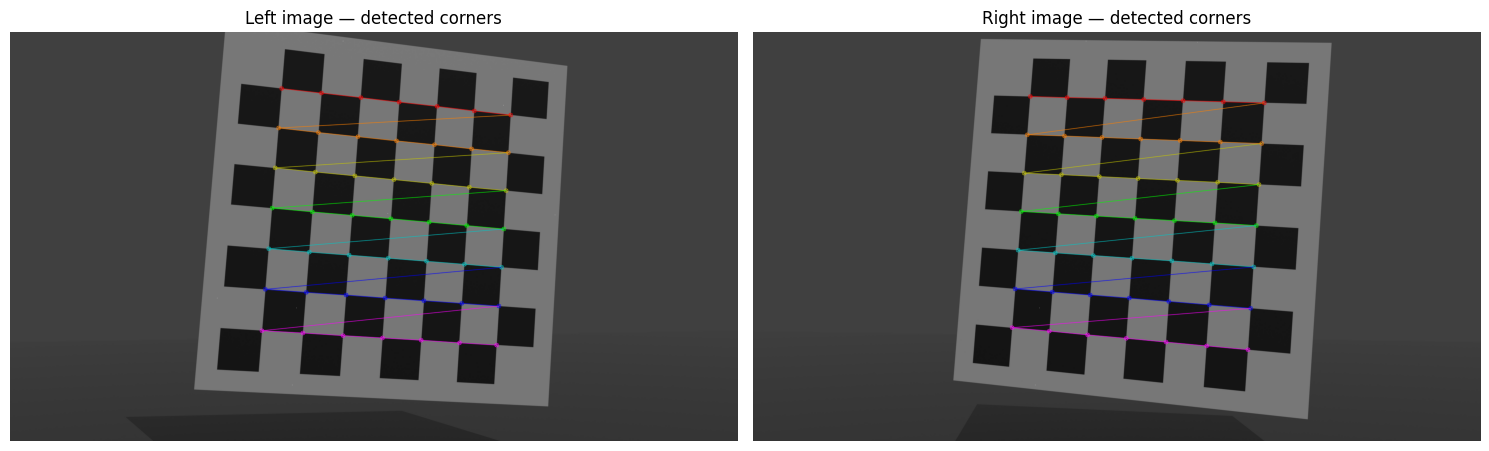

In [8]:
okL, cornersL, imgL_draw = detect_chessboard_corners(REF_LEFT, pattern_size)
okR, cornersR, imgR_draw = detect_chessboard_corners(REF_RIGHT, pattern_size)

print(f"Corner detection - Left: {okL} | Right: {okR}")
if okL: print("Left corners shape :", cornersL.shape)
if okR: print("Right corners shape:", cornersR.shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.imshow(imgL_draw); ax1.set_title("Left image — detected corners"); ax1.axis("off")
ax2.imshow(imgR_draw); ax2.set_title("Right image — detected corners"); ax2.axis("off")
plt.tight_layout()
plt.show()


### debug

In [9]:
# nx, ny = pattern_size  # (7,7)
# objp = np.zeros((nx * ny, 3), np.float32)
# objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
# objp *= square_size

# CB_LEFT  = sorted(glob.glob(str(CB_DIR / "*Left*.png")))
# CB_RIGHT = sorted(glob.glob(str(CB_DIR / "*Right*.png")))

# objpoints, imgpointsL, imgpointsR = [], [], []
# bad_pairs = []

# for left_path, right_path in zip(CB_LEFT, CB_RIGHT):
#     okL, cornersL, _ = detect_chessboard_corners(left_path, pattern_size)
#     okR, cornersR, _ = detect_chessboard_corners(right_path, pattern_size)

#     if okL and okR:
#         objpoints.append(objp.copy())
#         imgpointsL.append(cornersL.astype(np.float32))
#         imgpointsR.append(cornersR.astype(np.float32))
#     else:
#         bad_pairs.append((Path(left_path).name, Path(right_path).name, okL, okR))

# print("Good pairs:", len(objpoints))
# print("Bad pairs :", len(bad_pairs))
# print("Bad details:", bad_pairs)


# Calibration mono (caméra gauche et droite)

Chaque caméra est calibrée séparément à partir des vues du damier. Les faibles erreurs de reprojection indiquent une estimation fiable des paramètres intrinsèques, bien que le nombre limité de vues réduise la robustesse globale.

In [10]:
def build_object_points(pattern_size, square_size):
    """
    Construit les points 3D du damier dans le repère monde (plan Z = 0).
    Format compatible OpenCV : (N,3) float32
    """
    nx, ny = pattern_size
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    objp *= square_size
    return objp


def calibrate_mono(image_paths, pattern_size, square_size):
    """
    Calibre une caméra à partir de plusieurs vues du damier.

    - Les coins sont détectés avec une précision subpixel.
    - Seules les images où la détection est valide sont utilisées.
    - Les coins sont stockés au format (N,1,2) pour compatibilité stéréo.

    Retour :
        dict contenant :
        - rms        : erreur moyenne de reprojection (px)
        - K          : matrice intrinsèque
        - dist       : coefficients de distorsion
        - rvecs      : vecteurs de rotation
        - tvecs      : vecteurs de translation
        - used_images: liste des images utilisées
        - image_size : taille des images
    """
    objp = build_object_points(pattern_size, square_size)

    obj_pts, img_pts, used_imgs = [], [], []
    img_size = None

    print("\nDétection des coins pour calibration mono...")

    for path in image_paths:
        ok, corners, _ = detect_chessboard_corners(path, pattern_size)
        if not ok:
            print(f"Échec : {Path(path).name}")
            continue

        img = cv2.imread(str(path))
        h, w = img.shape[:2]

        if img_size is None:
            img_size = (w, h)
        elif img_size != (w, h):
            raise ValueError(f"Image size mismatch: {Path(path).name}")

        obj_pts.append(objp.copy())
        img_pts.append(corners.astype(np.float32))
        used_imgs.append(path)

        print(f"{Path(path).name} : {len(corners)} coins")

    if len(obj_pts) < 3:
        raise ValueError(f"Pas assez d'images valides : {len(obj_pts)} (min: 3)")

    print(f"\nCalibration avec {len(obj_pts)} images...")

    rms, K, dist, rvecs, tvecs = cv2.calibrateCamera(
        obj_pts, img_pts, img_size, None, None
    )

    print(f"RMS = {rms:.6f} px")

    return {
        "rms": float(rms),
        "K": K,
        "dist": dist,
        "rvecs": rvecs,
        "tvecs": tvecs,
        "used_images": used_imgs,
        "image_size": img_size
    }


In [11]:
left_paths  = sorted(Path(p) for p in glob.glob(str(CB_DIR / "*Left*.*")))
right_paths = sorted(Path(p) for p in glob.glob(str(CB_DIR / "*Right*.*")))

print("Found Left images :", len(left_paths))
print("Found Right images:", len(right_paths))

calibL = calibrate_mono(left_paths, pattern_size, square_size)
calibR = calibrate_mono(right_paths, pattern_size, square_size)

print("\nLEFT CAMERA")
print("RMS:", calibL["rms"])
print("K_L:\n", calibL["K"])
print("dist_L:", calibL["dist"].ravel())
print("Used images:", len(calibL["used_images"]))
print("Used list  :", [Path(p).name for p in calibL["used_images"]])  
print("image_size :", calibL["image_size"])                          

print("\nRIGHT CAMERA")
print("RMS:", calibR["rms"])
print("K_R:\n", calibR["K"])
print("dist_R:", calibR["dist"].ravel())
print("Used images:", len(calibR["used_images"]))
print("Used list  :", [Path(p).name for p in calibR["used_images"]])  
print("image_size :", calibR["image_size"])                          

# sécurité avant stereo
assert calibL["image_size"] == calibR["image_size"], "Left/Right image_size mismatch!"


Found Left images : 4
Found Right images: 4

Détection des coins pour calibration mono...
c1Left.png : 49 coins
c2Left.png : 49 coins
c3Left.png : 49 coins
c4Left.png : 49 coins

Calibration avec 4 images...
RMS = 0.038275 px

Détection des coins pour calibration mono...
c1Right.png : 49 coins
c2Right.png : 49 coins
c3Right.png : 49 coins
c4Right.png : 49 coins

Calibration avec 4 images...
RMS = 0.041815 px

LEFT CAMERA
RMS: 0.03827474159298447
K_L:
 [[2.09991466e+03 0.00000000e+00 9.60187506e+02]
 [0.00000000e+00 2.09991624e+03 5.38595868e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist_L: [-6.88040473e-03  1.42797318e-01 -1.76651995e-04  1.46989865e-04
 -3.30431598e-01]
Used images: 4
Used list  : ['c1Left.png', 'c2Left.png', 'c3Left.png', 'c4Left.png']
image_size : (1920, 1080)

RIGHT CAMERA
RMS: 0.04181482740498828
K_R:
 [[2.10006435e+03 0.00000000e+00 9.59760241e+02]
 [0.00000000e+00 2.09997317e+03 5.39852296e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist_R:

In [12]:
# # TEST ORDER (1 seule paire) : c1
# pL = CB_DIR / "c1Left.png"
# pR = CB_DIR / "c1Right.png"

# okL, cL, _ = detect_chessboard_corners(pL, pattern_size)
# okR, cR, _ = detect_chessboard_corners(pR, pattern_size)
# print("okL/okR:", okL, okR, "shapes:", cL.shape, cR.shape)

# # affiche 4 coins "repères" : (0), (cols-1), (-cols), (-1)
# cols, rows = pattern_size
# idxs = [0, cols-1, (rows-1)*cols, rows*cols-1]
# print("idxs:", idxs)

# print("LEFT repère:", [cL[i,0].tolist() for i in idxs])
# print("RIGHT repère:", [cR[i,0].tolist() for i in idxs])


# Géométrie épipolaire (estimation de la matrice fondamentale)

On valide la stéréovision via la matrice fondamentale estimée par RANSAC et l’erreur épipolaire point–ligne, qui est la métrique adaptée ici, plutôt que le RMS.

In [13]:
def collect_pairs_corners(left_paths, right_paths, pattern_size):
    """
    Collecte les correspondances (coins du damier) sur toutes les paires valides.
    Retour :
      - imgL_pts : liste de corners (N,1,2) float32
      - imgR_pts : liste de corners (N,1,2) float32
      - image_size : (w,h)
      - used_pairs : liste des paires utilisées (debug)
    """
    imgL_pts, imgR_pts = [], []
    used_pairs = []
    image_size = None

    for pL, pR in zip(left_paths, right_paths):
        okL, cL, _ = detect_chessboard_corners(pL, pattern_size)
        okR, cR, _ = detect_chessboard_corners(pR, pattern_size)
        if not (okL and okR):
            continue

        img = cv2.imread(str(pL))
        h, w = img.shape[:2]
        if image_size is None:
            image_size = (w, h)
        elif image_size != (w, h):
            raise ValueError(f"Image size mismatch: {Path(pL).name}")

        imgL_pts.append(cL.astype(np.float32))
        imgR_pts.append(cR.astype(np.float32))
        used_pairs.append((Path(pL).name, Path(pR).name))

    if len(imgL_pts) < 2:
        raise RuntimeError(f"Pas assez de paires valides pour estimer F: {len(imgL_pts)}")

    return imgL_pts, imgR_pts, image_size, used_pairs


def epipolar_error_pixels(F, ptsL, ptsR):
    """
    Erreur épipolaire point–ligne (pixels) :
    - calcule les lignes épipolaires dans l’image droite à partir des points gauche
    - calcule la distance du point droit à sa ligne
    """
    ptsL = ptsL.reshape(-1, 2)
    ptsR = ptsR.reshape(-1, 2)

    linesR = cv2.computeCorrespondEpilines(ptsL.reshape(-1, 1, 2), 1, F).reshape(-1, 3)

    num = np.abs(linesR[:, 0] * ptsR[:, 0] + linesR[:, 1] * ptsR[:, 1] + linesR[:, 2])
    den = np.sqrt(linesR[:, 0] ** 2 + linesR[:, 1] ** 2) + 1e-12
    return num / den



# Exécution

imgL_pts, imgR_pts, img_size, used_pairs = collect_pairs_corners(
    left_paths, right_paths, pattern_size
)

print("\nBLOC 3 — Géométrie épipolaire")
print("Paires utilisées:", used_pairs)
print("image_size:", img_size)

# Empiler tous les points (toutes les paires)
ptsL_all = np.vstack([p.reshape(-1, 2) for p in imgL_pts]).astype(np.float32)
ptsR_all = np.vstack([p.reshape(-1, 2) for p in imgR_pts]).astype(np.float32)

# Estimation robuste de F avec RANSAC
F_data, inlier_mask = cv2.findFundamentalMat(
    ptsL_all, ptsR_all,
    method=cv2.FM_RANSAC,
    ransacReprojThreshold=1.0,
    confidence=0.999
)

if F_data is None or F_data.shape != (3, 3):
    raise RuntimeError("findFundamentalMat a échoué : F_data invalide")

inliers = int(inlier_mask.sum()) if inlier_mask is not None else 0
print("inliers:", inliers, "/", len(ptsL_all))
print("F_data:\n", F_data)

# Validation par erreur épipolaire point–ligne
errs = epipolar_error_pixels(
    F_data,
    ptsL_all.reshape(-1, 1, 2),
    ptsR_all.reshape(-1, 1, 2)
)

print("Erreur épipolaire (pixels) — mean/median/max:",
      float(errs.mean()), float(np.median(errs)), float(errs.max()))



BLOC 3 — Géométrie épipolaire
Paires utilisées: [('c1Left.png', 'c1Right.png'), ('c2Left.png', 'c2Right.png'), ('c3Left.png', 'c3Right.png'), ('c4Left.png', 'c4Right.png')]
image_size: (1920, 1080)
inliers: 196 / 196
F_data:
 [[ 4.04912880e-10  7.84736609e-07 -5.09046661e-04]
 [ 8.45690475e-07 -1.05223632e-08 -9.32213308e-03]
 [-5.44357660e-04  7.78370326e-03  1.00000000e+00]]
Erreur épipolaire (pixels) — mean/median/max: 0.055504702031612396 0.0527801513671875 0.16876220703125


# LIGNES ÉPIPOLAIRES 

Les lignes épipolaires permettent de visualiser la contrainte géométrique imposée par la matrice fondamentale. À partir d’un point dans une image, la géométrie épipolaire impose que son point correspondant dans l’autre image se situe sur une droite appelée ligne épipolaire.
Dans ce projet, les coins du damier fournissent des correspondances précises entre les vues gauche et droite. À l’aide de la matrice fondamentale estimée précédemment, les lignes épipolaires correspondantes sont calculées et superposées aux images. L’alignement des points avec leurs lignes épipolaires constitue une validation visuelle directe de la cohérence géométrique du système.

---


Les lignes épipolaires visualisent la contrainte géométrique imposée par la matrice fondamentale : chaque point correspondant doit appartenir à sa ligne épipolaire.

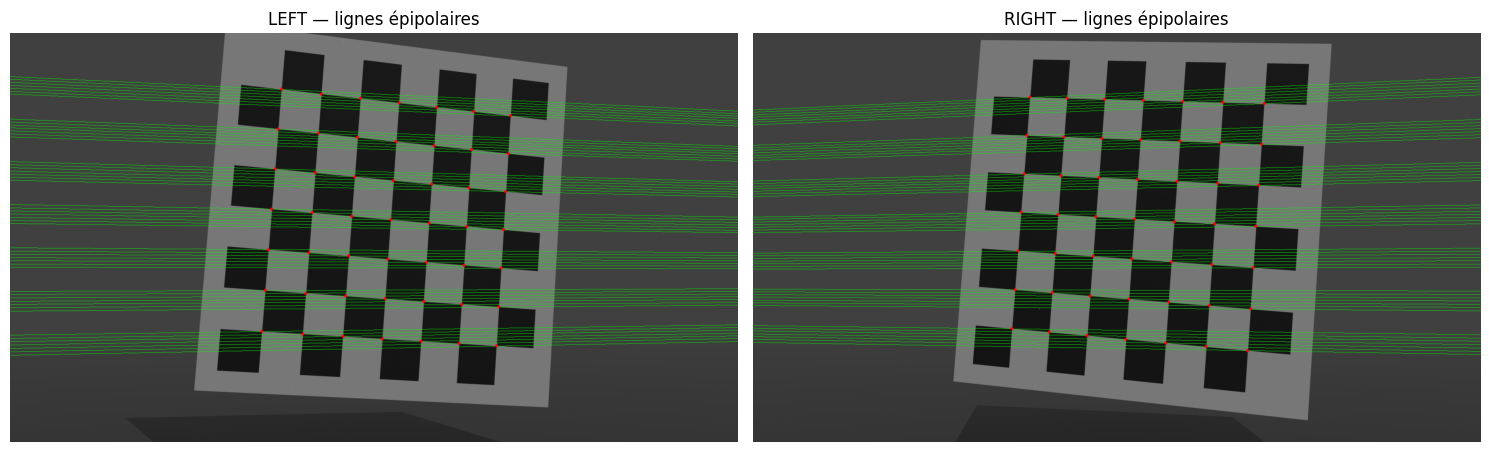

In [14]:
# Chargement de la paire de référence
imgL_bgr = cv2.imread(str(REF_LEFT))
imgR_bgr = cv2.imread(str(REF_RIGHT))

imgL = cv2.cvtColor(imgL_bgr, cv2.COLOR_BGR2RGB)
imgR = cv2.cvtColor(imgR_bgr, cv2.COLOR_BGR2RGB)

# Détection des coins du damier (correspondances précises)
okL, cornersL, _ = detect_chessboard_corners(REF_LEFT, pattern_size)
okR, cornersR, _ = detect_chessboard_corners(REF_RIGHT, pattern_size)

if not (okL and okR):
    raise RuntimeError("Damier non détecté sur la paire de référence.")

# Chaque indice i correspond à une paire de points correspondants
ptsL = cornersL.reshape(-1, 2)  # (N,2)
ptsR = cornersR.reshape(-1, 2)  # (N,2)

# Matrice fondamentale estimée précédemment
F = F_data.astype(np.float64)

# Lignes épipolaires dans l'image droite (depuis les points gauche)
linesR = cv2.computeCorrespondEpilines(
    ptsL.reshape(-1, 1, 2), 1, F
).reshape(-1, 3)

# Lignes épipolaires dans l'image gauche (depuis les points droit)
linesL = cv2.computeCorrespondEpilines(
    ptsR.reshape(-1, 1, 2), 2, F
).reshape(-1, 3)

def draw_epilines(img_rgb, lines, pts, n=60):
    """
    Dessine n lignes épipolaires et leurs points associés.
    lines : (N,3) avec ax + by + c = 0
    pts   : (N,2) points correspondants
    """
    h, w = img_rgb.shape[:2]
    out = img_rgb.copy()

    n = min(n, len(lines))
    for i in range(n):
        a, b, c = lines[i]
        if abs(b) < 1e-9:
            continue

        x0, x1 = 0, w - 1
        y0 = int(round(-(a * x0 + c) / b))
        y1 = int(round(-(a * x1 + c) / b))

        cv2.line(out, (x0, y0), (x1, y1), (0, 255, 0), 1)

        x, y = pts[i]
        cv2.circle(out, (int(x), int(y)), 4, (255, 0, 0), -1)

    return out

# Visualisation
imgL_draw = draw_epilines(imgL, linesL, ptsL)
imgR_draw = draw_epilines(imgR, linesR, ptsR)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.imshow(imgL_draw); ax1.set_title("LEFT — lignes épipolaires"); ax1.axis("off")
ax2.imshow(imgR_draw); ax2.set_title("RIGHT — lignes épipolaires"); ax2.axis("off")
plt.tight_layout()
plt.show()


# Rectification épipolaire (images de référence / damier)

La rectification transforme les images de manière à rendre les lignes épipolaires horizontales, ce qui réduit la recherche de correspondances à une seule dimension.

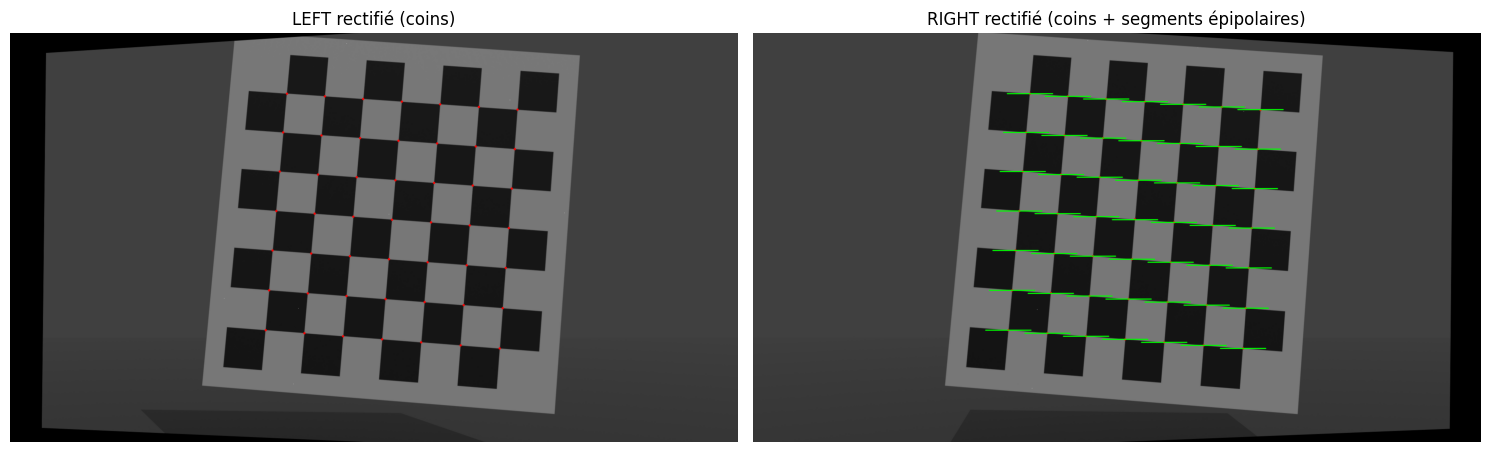

In [15]:
imgL = cv2.imread(str(REF_LEFT))
imgR = cv2.imread(str(REF_RIGHT))

if imgL is None or imgR is None:
    raise FileNotFoundError("Images de référence introuvables")

h, w = imgL.shape[:2]
image_size = (w, h)

# Détection des coins (correspondances fiables)
okL, cornersL, _ = detect_chessboard_corners(REF_LEFT, pattern_size)
okR, cornersR, _ = detect_chessboard_corners(REF_RIGHT, pattern_size)
if not (okL and okR):
    raise RuntimeError("Damier non détecté sur la paire de référence")

ptsL = cornersL.reshape(-1, 2)
ptsR = cornersR.reshape(-1, 2)

# Rectification non calibrée à partir de F
F = F_data.astype(np.float64)
_, H1, H2 = cv2.stereoRectifyUncalibrated(ptsL, ptsR, F, image_size)

# Application des homographies
rectL = cv2.warpPerspective(imgL, H1, image_size)
rectR = cv2.warpPerspective(imgR, H2, image_size)

rectL_rgb = cv2.cvtColor(rectL, cv2.COLOR_BGR2RGB)
rectR_rgb = cv2.cvtColor(rectR, cv2.COLOR_BGR2RGB)

# Transformation des points dans le repère rectifié
ptsL_rect = cv2.perspectiveTransform(
    ptsL.astype(np.float32).reshape(-1,1,2), H1
).reshape(-1,2)

ptsR_rect = cv2.perspectiveTransform(
    ptsR.astype(np.float32).reshape(-1,1,2), H2
).reshape(-1,2)

# Visualisation : points + segments épipolaires
left_vis  = rectL_rgb.copy()
right_vis = rectR_rgb.copy()

for (xL, yL), (xR, yR) in zip(ptsL_rect, ptsR_rect):
    xL_i, yL_i = int(round(xL)), int(round(yL))
    xR_i, yR_i = int(round(xR)), int(round(yR))

    cv2.circle(left_vis,  (xL_i, yL_i), 3, (255,0,0), -1)
    cv2.circle(right_vis, (xR_i, yR_i), 3, (255,0,0), -1)

    # segment horizontal (validation de la rectification)
    y = yL_i
    if 0 <= y < right_vis.shape[0]:
        cv2.line(right_vis,
                 (xR_i-60, y),
                 (xR_i+60, y),
                 (0,255,0), 2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.imshow(left_vis);  ax1.set_title("LEFT rectifié (coins)"); ax1.axis("off")
ax2.imshow(right_vis); ax2.set_title("RIGHT rectifié (coins + segments épipolaires)"); ax2.axis("off")
plt.tight_layout()
plt.show()


In [16]:
dy = np.abs(ptsL_rect[:,1] - ptsR_rect[:,1])
print("dy mean:", dy.mean(), "max:", dy.max())


dy mean: 0.06459201 max: 0.16363525


# Rectification des images de scan (LASER)

Une fois la rectification épipolaire validée sur les images de référence, les mêmes homographies sont appliquées aux images de scan contenant le laser. Cette étape garantit que les images de scan respectent la même géométrie épipolaire, condition nécessaire à l’extraction et à l’appariement du laser.

---

Les homographies de rectification sont ensuite appliquées aux images de scan afin d’assurer la cohérence géométrique avant l’extraction du laser.

Nombre de scans : 26


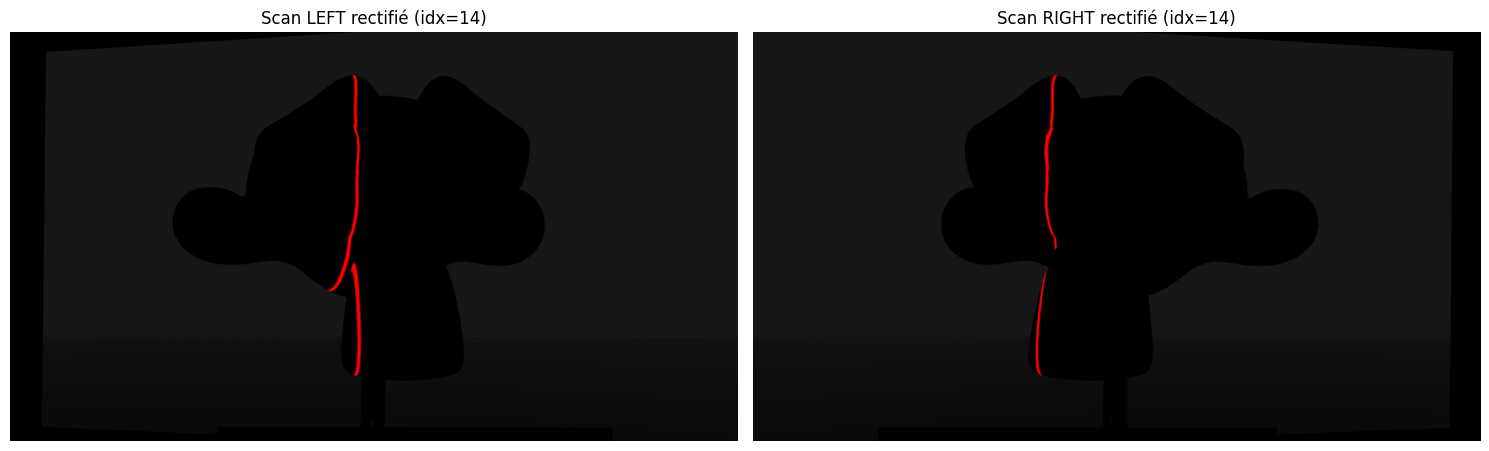

In [17]:
SCAN_LEFT  = sorted(glob.glob(SCAN_LEFT_DIR))
SCAN_RIGHT = sorted(glob.glob(SCAN_RIGHT_DIR))

assert len(SCAN_LEFT) == len(SCAN_RIGHT), "Nombre de scans gauche/droite différent"
print("Nombre de scans :", len(SCAN_LEFT))

idx = 14  # scan de test (à changer si besoin)
imgL = cv2.imread(SCAN_LEFT[idx])
imgR = cv2.imread(SCAN_RIGHT[idx])

if imgL is None or imgR is None:
    raise FileNotFoundError("Scan images not found")

h, w = imgL.shape[:2]
image_size = (w, h)

# Application des homographies de rectification
rectScanL = cv2.warpPerspective(imgL, H1, image_size)
rectScanR = cv2.warpPerspective(imgR, H2, image_size)

# Contrôle visuel : vérifier que le laser est visible après rectification
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

ax1.imshow(cv2.cvtColor(rectScanL, cv2.COLOR_BGR2RGB))
ax1.set_title(f"Scan LEFT rectifié (idx={idx})")
ax1.axis("off")

ax2.imshow(cv2.cvtColor(rectScanR, cv2.COLOR_BGR2RGB))
ax2.set_title(f"Scan RIGHT rectifié (idx={idx})")
ax2.axis("off")

plt.tight_layout()
plt.show()


# Extraction du laser (scans rectifiés)

Après rectification des images de scan, le laser est extrait indépendamment dans chaque vue par segmentation couleur en espace HSV. Deux plages de teintes sont utilisées afin de couvrir le rouge (qui traverse la discontinuité 0°/180° en HSV).
Un masque binaire est obtenu, puis légèrement nettoyé afin de réduire le bruit. Les pixels détectés sont convertis en un ensemble de points (x,y). 
Enfin, pour obtenir une représentation compacte et stable du trait laser, un seul point est conservé par ligne horizontale y, en prenant la médiane des positions x. Cette étape facilite l’appariement stéréo ultérieur après rectification.

---

J’extrais le laser par seuillage HSV du rouge, puis je compresse à un point par ligne (médiane) pour obtenir un signal propre et facile à apparier.

Laser LEFT : (792, 2)
Laser RIGHT: (730, 2)


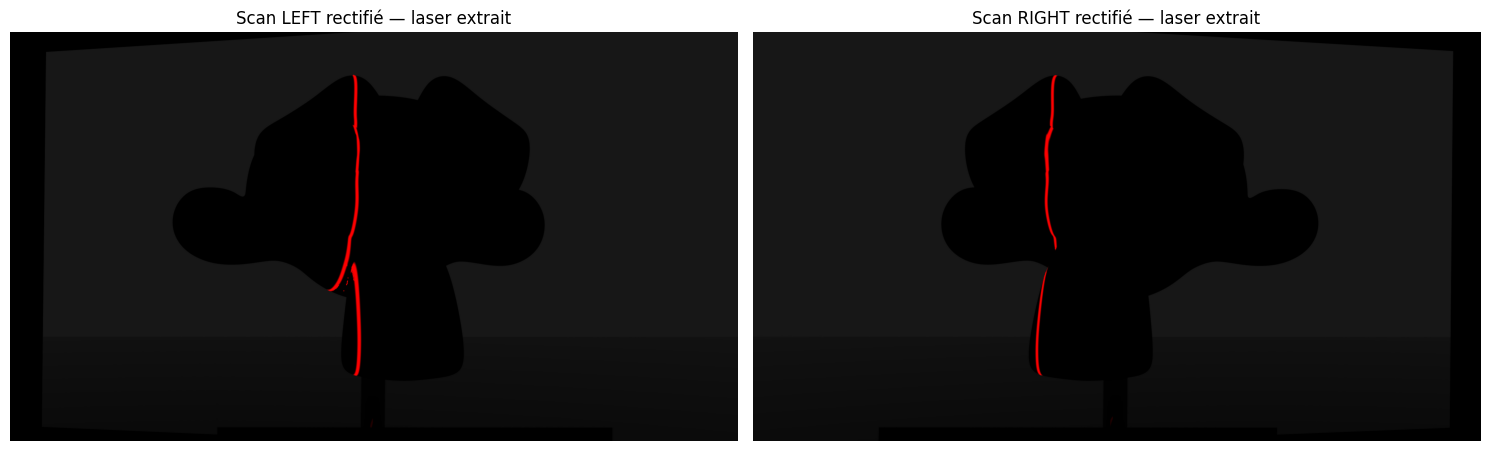

Mask coverage L (%): 0.4205729166666667
Mask coverage R (%): 0.2798514660493827


In [18]:
def extract_laser_points_red(bgr):
    """
    Détecte les pixels du laser rouge par seuillage HSV.
    Retour :
      - mask : masque binaire du laser
      - pts  : array (N,2) float32 des points (x,y)
    """
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)

    # Rouge = 2 plages HSV 
    mask1 = cv2.inRange(hsv, (0, 120, 80), (10, 255, 255))
    mask2 = cv2.inRange(hsv, (170, 120, 80), (180, 255, 255))
    mask = cv2.bitwise_or(mask1, mask2)

    # Nettoyage léger pour réduire le bruit
    mask = cv2.medianBlur(mask, 5)

    ys, xs = np.where(mask > 0)
    pts = np.stack([xs, ys], axis=1).astype(np.float32)
    return mask, pts


def compress_laser_by_row(pts, h):
    """
    Réduit le nuage de pixels du laser à un point par ligne y :
    pour chaque y, conserve un seul x (médiane).
    """
    if len(pts) == 0:
        return np.empty((0, 2), dtype=np.int32)

    pts_i = np.round(pts).astype(int)
    pts_i = pts_i[(pts_i[:, 1] >= 0) & (pts_i[:, 1] < h)]

    out = []
    for y in np.unique(pts_i[:, 1]):
        xs = pts_i[pts_i[:, 1] == y][:, 0]
        out.append([int(np.median(xs)), int(y)])

    return np.array(out, dtype=np.int32)


# rectScanL et rectScanR proviennent du BLOC 6 
maskL, ptsL_raw = extract_laser_points_red(rectScanL)
maskR, ptsR_raw = extract_laser_points_red(rectScanR)

h, w = rectScanL.shape[:2]

laserL = compress_laser_by_row(ptsL_raw, h)
laserR = compress_laser_by_row(ptsR_raw, h)

print("Laser LEFT :", laserL.shape)
print("Laser RIGHT:", laserR.shape)

# Visualisation 
L_vis = cv2.cvtColor(rectScanL, cv2.COLOR_BGR2RGB)
R_vis = cv2.cvtColor(rectScanR, cv2.COLOR_BGR2RGB)

# Afficher un point sur 2 pour la lisibilité
for x, y in laserL[::2]:
    cv2.circle(L_vis, (x, y), 1, (255, 0, 0), -1)

for x, y in laserR[::2]:
    cv2.circle(R_vis, (x, y), 1, (255, 0, 0), -1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.imshow(L_vis); ax1.set_title("Scan LEFT rectifié — laser extrait"); ax1.axis("off")
ax2.imshow(R_vis); ax2.set_title("Scan RIGHT rectifié — laser extrait"); ax2.axis("off")
plt.tight_layout()
plt.show()

print("Mask coverage L (%):", 100.0 * maskL.mean() / 255.0)
print("Mask coverage R (%):", 100.0 * maskR.mean() / 255.0)


# Matching laser 

Grâce à la rectification épipolaire, les correspondances entre les deux vues se trouvent sur la même ligne horizontale, ce qui réduit le problème d’appariement à une dimension.
Le trait laser étant compressé à un point par ligne y, l’appariement consiste à associer les points ayant une coordonnée y commune dans les deux images. La disparité est alors définie par d=xL−xR.
Un filtrage simple sur la disparité permet de rejeter les correspondances instables dues au bruit ou à des pixels parasites.

---
Après rectification,yL≈yR, donc je match le laser par y et je calcule la disparité d=xL−xR.


Nombre de lignes matchées : 730
Matches valides : (730, 4)


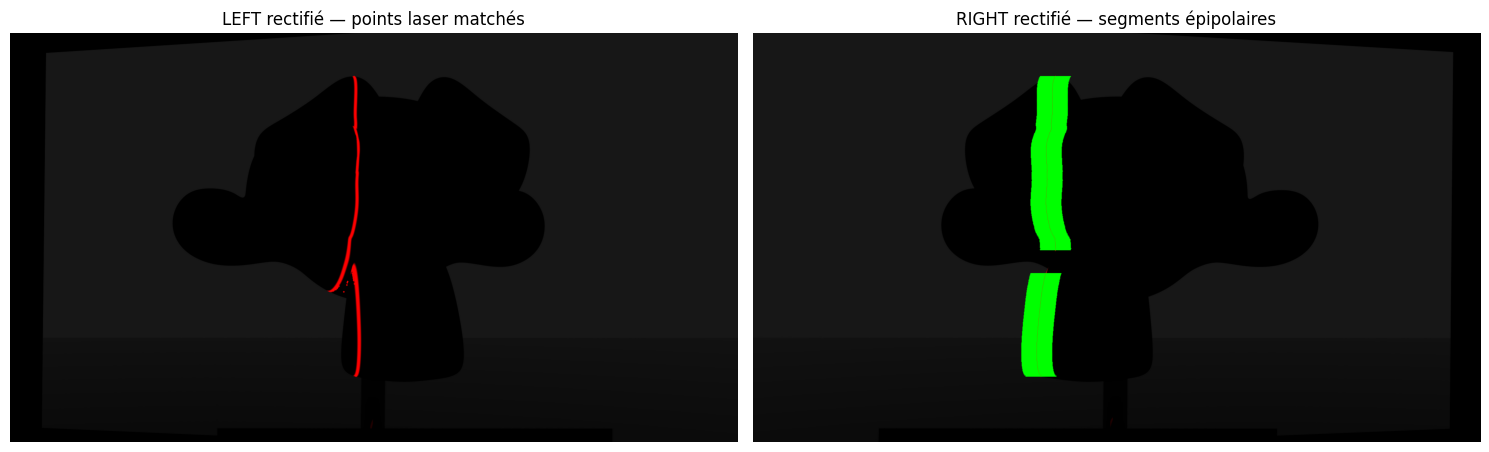

In [19]:
dictL = {int(y): int(x) for x, y in laserL}
dictR = {int(y): int(x) for x, y in laserR}

# Lignes communes
ys_common = sorted(set(dictL.keys()) & set(dictR.keys()))
print("Nombre de lignes matchées :", len(ys_common))

matches = []
min_disp = 1  # seuil simple pour éviter les matchs quasi nuls 

for y in ys_common:
    xL = dictL[y]
    xR = dictR[y]
    d  = xL - xR  # disparité

    if abs(d) > min_disp:
        matches.append((xL, y, xR, d))

matches = np.array(matches, dtype=np.float64)
print("Matches valides :", matches.shape)


# Visualisation des correspondances et des segments épipolaires

L_vis = cv2.cvtColor(rectScanL, cv2.COLOR_BGR2RGB)
R_vis = cv2.cvtColor(rectScanR, cv2.COLOR_BGR2RGB)

seg = 40
th  = 2

for (xL, y, xR, d) in matches[::3]:  
    xL, y, xR = int(xL), int(y), int(xR)

    cv2.circle(L_vis, (xL, y), 2, (255, 0, 0), -1)
    cv2.circle(R_vis, (xR, y), 2, (255, 0, 0), -1)

    # segment horizontal sur l'image droite 
    cv2.line(R_vis, (xR - seg, y), (xR + seg, y), (0, 255, 0), th)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.imshow(L_vis); ax1.set_title("LEFT rectifié — points laser matchés"); ax1.axis("off")
ax2.imshow(R_vis); ax2.set_title("RIGHT rectifié — segments épipolaires"); ax2.axis("off")
plt.tight_layout()
plt.show()


# Triangulation 3D avec P1 / P2

Pour la 3D, je fixe les intrinsèques mono, j’estime R,T avec stereoCalibrate, je récupère P1,P2 via stereoRectify, puis je triangule les points laser. Le RMS stéréo est informatif car le jeu de données est réduit ; la cohérence est validée visuellement et par filtrage.

## construction des points stéréo

Pour la calibration stéréo, j’utilise les mêmes points 3D théoriques du damier que pour la calibration mono, mais uniquement sur les paires gauche/droite où les deux damiers sont détectés. Cela garantit des correspondances cohérentes pour estimer la pose relative.

In [20]:
def collect_stereo_calib_points(left_paths, right_paths, pattern_size, square_size):
    """
    Construit les données nécessaires à stereoCalibrate :
      - objpoints  : liste de (N,3)
      - imgpointsL : liste de (N,1,2)
      - imgpointsR : liste de (N,1,2)
    """
    objp = build_object_points(pattern_size, square_size)

    objpoints = []
    imgpointsL = []
    imgpointsR = []

    for pL, pR in zip(left_paths, right_paths):
        okL, cL, _ = detect_chessboard_corners(pL, pattern_size)
        okR, cR, _ = detect_chessboard_corners(pR, pattern_size)

        if not (okL and okR):
            continue

        objpoints.append(objp.copy())
        imgpointsL.append(cL.astype(np.float32))
        imgpointsR.append(cR.astype(np.float32))

    if len(objpoints) < 2:
        raise RuntimeError(
            f"Pas assez de paires valides pour stereoCalibrate : {len(objpoints)}"
        )

    return objpoints, imgpointsL, imgpointsR

objpoints, imgpointsL, imgpointsR = collect_stereo_calib_points(
    left_paths,
    right_paths,
    pattern_size,
    square_size
)

print("Paires stéréo utilisées :", len(objpoints))


Paires stéréo utilisées : 4


## stereoCalibrate

In [21]:
assert len(objpoints) == len(imgpointsL) == len(imgpointsR), "obj/img points mismatch"

flags = cv2.CALIB_FIX_INTRINSIC

ret, _, _, _, _, R, T, E, F_stereo = cv2.stereoCalibrate(
    objpoints,
    imgpointsL,
    imgpointsR,
    calibL["K"], calibL["dist"],
    calibR["K"], calibR["dist"],
    calibL["image_size"],
    flags=flags,
    criteria=(cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-5)
)

print("Stereo RMS (info only) :", ret)
print("R:\n", R)
print("T:\n", T)


Stereo RMS (info only) : 12.368011687364298
R:
 [[ 0.94147842  0.01625203  0.33668123]
 [-0.0158248   0.99986673 -0.00401317]
 [-0.33670158 -0.0015496   0.94161013]]
T:
 [[-7.34470558]
 [ 0.07630574]
 [ 1.08951836]]


## stereoRectify → P1 / P2

In [22]:
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
    calibL["K"], calibL["dist"],
    calibR["K"], calibR["dist"],
    calibL["image_size"],
    R, T,
    flags=cv2.CALIB_ZERO_DISPARITY,
    alpha=0
)

print("P1 shape:", P1.shape)
print("P2 shape:", P2.shape)


P1 shape: (3, 4)
P2 shape: (3, 4)


## Triangulation 3D (P1 / P2)


ptsL shape: (2, 730)
ptsR shape: (2, 730)
Nuage 3D brut : (730, 3)
Nuage 3D filtré : (580, 3)


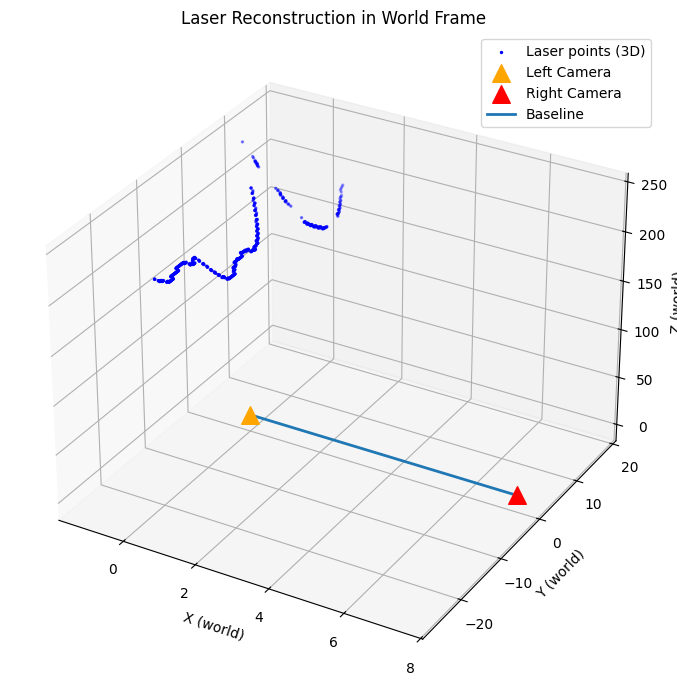

In [23]:
ptsL = np.vstack([matches[:, 0], matches[:, 1]]).astype(np.float64)
ptsR = np.vstack([matches[:, 2], matches[:, 1]]).astype(np.float64)

print("ptsL shape:", ptsL.shape)
print("ptsR shape:", ptsR.shape)

X_h = cv2.triangulatePoints(P1, P2, ptsL, ptsR)
X = (X_h[:3] / X_h[3]).T
print("Nuage 3D brut :", X.shape)

# Filtrage
# supprime NaN/Inf
X = X[np.isfinite(X).all(axis=1)]

# garde seulement les points "devant" la caméra (Z>0)
X = X[X[:, 2] > 0]

# coupe les extrêmes en profondeur 
if len(X) > 10:
    Z = X[:, 2]
    z_min, z_max = np.percentile(Z, [10, 90])
    X = X[(Z > z_min) & (Z < z_max)]

print("Nuage 3D filtré :", X.shape)

def camera_center_from_P(P):
    """
    Calcule le centre caméra C (3,) à partir de P (3x4)
    en supposant que M = P[:,:3] est inversible.
    """
    M = P[:, :3]
    p4 = P[:, 3]
    return -np.linalg.inv(M) @ p4

C1 = camera_center_from_P(P1)   # caméra gauche (référence)
C2 = camera_center_from_P(P2)   # caméra droite


# Visualisation 3D (nuage + caméras + baseline)

fig = plt.figure(figsize=(9, 7))
ax = fig.add_subplot(111, projection="3d")

# nuage laser
ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=2, c="b", label="Laser points (3D)")

# caméras
ax.scatter(C1[0], C1[1], C1[2], s=160, marker="^", c="orange", label="Left Camera")
ax.scatter(C2[0], C2[1], C2[2], s=160, marker="^", c="red", label="Right Camera")

# baseline (segment entre caméras)
ax.plot([C1[0], C2[0]], [C1[1], C2[1]], [C1[2], C2[2]], linewidth=2, label="Baseline")

ax.set_xlabel("X (world)")
ax.set_ylabel("Y (world)")
ax.set_zlabel("Z (world)")
ax.set_title("Laser Reconstruction in World Frame")
ax.legend(loc="upper right")

plt.tight_layout()
plt.show()